# Hand digit classifier 
---
## Incremental network quantization

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from skimage import io
import os

### Importing MNIST dataset

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_data = torchvision.datasets.MNIST(root='../', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root="../", train=False, download=True, transform=transform)

train_set = [train_data[i] for i in range(50000)]
validation_set = [train_data[i] for i in range(50000, 60000)]

### Setting up data loaders

In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

### Definig a VGG-7 inspired architecture model
---
Featuring 4 convolutional and 3 fully connected layers

In [5]:
class VGG7(nn.Module):
    def __init__(self):
        super(VGG7, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding="same", stride=1, bias=False)
        self.conv2 = nn.Conv2d(64, 64, 3, padding="same", stride=1, bias=False)
        self.conv3 = nn.Conv2d(64, 128, 3, padding="same", stride=1, bias=False)
        self.conv4 = nn.Conv2d(128, 128, 3, padding="same", stride=1, bias=False)
        
        self.fc1 = nn.Linear(7*7*128, 512, bias=False)
        self.fc2 = nn.Linear(512, 256, bias=False)
        self.fc3 = nn.Linear(256, 10, bias=False)

    def forward(self, x): 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, stride=2)  

        x = x.view(-1, 7*7*128)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)  

        x = F.log_softmax(x, dim=1)  

        return x

### Utility functions

In [5]:
def getNNSize(number_of_bits, parameters):
    return number_of_bits*getNumberOfWeights(parameters)*1.25e-7


def getNumberOfWeights(parameters):
    number_of_weights = 0

    for param in parameters:
        number_of_weights_layer = 1
        for n in param.size():
            number_of_weights_layer *= n
        number_of_weights += number_of_weights_layer

    return number_of_weights


def recordResultsInfile(accuracy, number_of_bits, parameters):
    if not os.path.isdir("./Records"):
        os.mkdir("./Records")

    nn_size = getNNSize(number_of_bits, parameters)
    try:
        f = open("./Records/TrainingHistory.txt", "a")
        f.write("-"*50+"\n")
        f.write("Bit-width: {}\nAccuracy: {:.2f}%\nSize: {:.2f} MB\n".format( 
            number_of_bits, accuracy, nn_size
        ))
        f.write("-"*50+"\n")
    except (Exception):
        print(Exception)
    finally:    
        f.close()


def evaluateModel(net, test_loader, number_of_bits, save):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)
    net.eval()

    correct = 0
    loss = 0
    confusion_matrix = np.zeros((10, 10))

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            loss += F.nll_loss(output, target, reduction="sum").item()
            confusion_matrix[pred.view(-1), target] += 1

    accuracy = 100.*(correct/len(test_loader.dataset))
    print("[OK] Model evaluation complete [OK]")
    print("Average loss: {:.5f}".format(loss/len(test_loader.dataset)))
    print("Accuracy: {:.2f}%".format(accuracy))

    if save:
        recordResultsInfile(accuracy, number_of_bits, net.parameters())

    fig, ax = plt.subplots()
    ax.imshow(confusion_matrix/len(train_loader.dataset))
    ax.set_xticks(np.arange(10))
    ax.set_yticks(np.arange(10))
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predictions")
    ax.set_title("Confusion matrix")
    fig.set_size_inches(4, 4)

### Shift Quantization operations

In [6]:
def getBounderyExponents(W, b):
    s = torch.max(torch.abs(W)).item()
    n1 = np.floor(np.log2(4*(s/3)))
    n2 = n1 + 1 - (2**(b - 1))/2
    return n1, n2


def getQuantizationMask(W, percentage, T):
    w = W.view(-1)
    t = T.view(-1)
    idx = t == 1

    numberOfWeights = w.size(dim=0)
    numberOfQWeights = int(percentage*numberOfWeights - t[idx].size(dim=0))

    t_aux = torch.Tensor(np.ones_like(T)).view(-1)
    w = w*(t_aux - t)
    w = torch.abs(w)
    sorted_w, indices_w = w.sort()
    t[indices_w[-numberOfQWeights:]] = 1
    
    return t.view(T.size())


def getFcQuantizationMask(In, percentage, T):
    Ax = torch.Tensor(np.zeros_like(In.data))
    eps = 1e-45

    for i in range(len(In)):
      Ax[i] = torch.where(T[i] == 0, In[i], 0)
      if T[i] == 0 and In[i] == 0:
        Ax[i] = eps

    w_abs=torch.abs(Ax)
    values_sort,indexes_sort=torch.sort(w_abs,descending=True)
    count = torch.sum(T == 1)
    k=np.floor(len(In)*percentage)-count
    k=int(k)

    if k < 0:
      k = 0

    sorted_indexes=indexes_sort[:int(k)]

    for i in range(len(sorted_indexes)):
        T[sorted_indexes[i]] = 1


def quantizeWeights(W, T, n1, n2):
    T_aux = torch.Tensor(np.ones_like(T))
    eps = 1e-6
    W1 = W*(T_aux - T)
    idx = W == 0
    W.data[idx] = eps

    closestExp = torch.floor(torch.log2(torch.abs(W*4/3)))
    Q = W1 + torch.sign(W)*(2**closestExp)*T

    idx = closestExp*T < n2
    Q[idx] = 0
    idx = ((closestExp > n1)*T).bool()
    Q[idx] = 2**n1

    return closestExp, Q


def quantize_conv_layer(W, T, percentage, number_of_bits):
    n = T.size(dim=0)
    m = T.size(dim=1)

    n1, n2 = getBounderyExponents(W, number_of_bits)

    for i in range(n):
        for j in range(m):
            T[i, j, :, :] = getQuantizationMask(W[i, j, :, :], percentage, T[i, j, :, :])
            _, W.data[i, j, :, :] = quantizeWeights(W[i, j, :, :], T[i, j, :, :], n1, n2)


def quantize_fc_layer(W, T, percentage, number_of_bits):
    n1, n2 = getBounderyExponents(W, number_of_bits)
    n = W.size(dim=1)

    for i in range(n):
        getFcQuantizationMask(W[:, i], percentage, T[:, i])
        _, W.data[:, i] = quantizeWeights(W[:, i], T[:, i], n1, n2)
        

def generateMasks(parameters):
    T = []
    for param in parameters:
        T.append(torch.zeros_like(param))

    return T


def quantizeNN(net, T, percentage, number_of_bits):
    for (index, layer) in enumerate(net.parameters()):
        if len(layer.size()) == 4:
            quantize_conv_layer(layer, T[index], percentage, number_of_bits)
        if len(layer.size()) == 2:
            quantize_fc_layer(layer, T[index], percentage, number_of_bits)


def freezeWeights(net, T):
    for (index, layer) in enumerate(net.parameters()):
        layer.grad = layer.grad*(torch.ones_like(T[index]) - T[index])

### Device initialization for training

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net = torch.load("../Baseline/baseline.pth")
net.to(device)

optimizer = optim.SGD(net.parameters(), lr = 1e-2, weight_decay=0)

quantization_percentages = [0.5, 0.75, 0.875]
quantization_precision = 3

epochs = 4
logs_interval = 100
iteration = 0
train_loss = []

T = generateMasks(net.parameters())

net.train()

for q_stage, percentage in enumerate(quantization_percentages):
    # quantize layers
    quantizeNN(net, T, percentage, quantization_precision)
    
    # correct remaining weights by training
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, target)
            loss.backward()

            # setam gradienti la 0
            freezeWeights(net, T) 
            optimizer.step()

            iteration = iteration + 1
            if iteration % logs_interval == 0:
                print('Quantization step: {}/{}, Train epoch:{}/{}, batch index:{}, loss:{}'.format(
                    q_stage + 1, len(quantization_percentages),
                    epoch + 1, epochs, batch_idx + 1, loss.item()/logs_interval))
                train_loss.append(loss.item())    

quantizeNN(net, T, 1, quantization_precision)

In [ ]:
evaluateModel(net, test_loader, quantization_precision, save=True)

In [ ]:
bit3_accuracy = np.array([97.76, 97.76, 97.76, 97.76, 97.76, 97.76, 97.78])

print("Mean: {:.2f}".format(bit3_accuracy.mean()))
print("Standard deviation: {}".format(bit3_accuracy.std()))

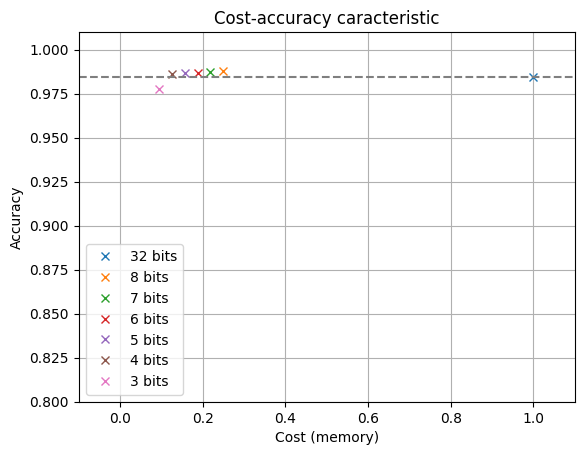

In [33]:
mo = np.array([98.45, 98.77, 98.74, 98.66, 98.7, 98.63, 97.76])/100
cost = np.array([14.41, 3.6, 3.15, 2.7, 2.25, 1.8, 1.35])/14.41

plt.plot(cost[0], mo[0], 'x')
plt.plot(cost[1], mo[1], 'x')
plt.plot(cost[2], mo[2], 'x')
plt.plot(cost[3], mo[3], 'x')
plt.plot(cost[4], mo[4], 'x')
plt.plot(cost[5], mo[5], 'x')
plt.plot(cost[6], mo[6], 'x')

x = np.arange(-0.1, 1.1, 0.01)
y = (98.45/100)*np.ones_like(x)
plt.plot(x, y, '--')

plt.xlim([-0.1, 1.1])
plt.ylim([0.8, 1.01])
plt.grid()
plt.xlabel("Cost (memory)")
plt.ylabel("Accuracy")
plt.title("Cost-accuracy caracteristic")

plt.legend((("32 bits"), ("8 bits"), ("7 bits"), ("6 bits"), ("5 bits"), ("4 bits"), ("3 bits")))